## 1. Pendahuluan

Penerapan ML dalam membantu klasifikasi kualitas udara. Tujuan analisis ini adalah membandingkan dua metode (Random Forest dan Logistic Regression) menggunakan data SPKU 2020 yang didapatkan dari website https://satudata.jakarta.go.id/.

---

## 2. Persiapan Lingkungan dan Import Library

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

## 3. Memuat dan Melihat Dataset
**Langkah 3:** Muat dataset CSV dan tampilkan nama kolom untuk verifikasi.

In [2]:
print("Memuat dataset...")
df = pd.read_csv('Stasiun Pemantau Kualitas Udara ( SPKU) Tahun 2020.csv')
print("Kolom pada dataset:")
print(df.columns.tolist())

Memuat dataset...
Kolom pada dataset:
['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori']


## 4. Pembersihan Data dan Preprocessing
**Langkah 4a: Konversi dan Validasi Tanggal**

In [3]:
# Konversi tanggal ke datetime, invalid format jadi NaT
df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
print(f"Baris dengan tanggal invalid: {df['tanggal'].isna().sum()}")

Baris dengan tanggal invalid: 0


/var/folders/rb/swpbdkdx0wqdp48gb6zpkpj40000gn/T/ipykernel_3466/1955351900.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')


**Langkah 4b: Tangani Missing Values**


In [4]:
# Drop missing pada kolom kategori saja (tanggal NaT masih bisa diproses)
df_cat = df.dropna(subset=['categori'])
print(f"Baris setelah drop kategori: {len(df_cat)} dari {len(df)}")

# Ganti '---' dengan NaN pada kolom polutan
cols_polutan = ['pm10','so2','co','o3','no2']
df_cat[cols_polutan] = df_cat[cols_polutan].replace('---', pd.NA)

# Ubah kolom-kolom polutan ke float
df_cat[cols_polutan] = df_cat[cols_polutan].fillna(0).astype(float)

# Imputasi median pada kolom polutan
df_imputed = df_cat.copy()
df_imputed[cols_polutan] = SimpleImputer(strategy='median').fit_transform(df_cat[cols_polutan])
print(f"Baris setelah imputasi: {len(df_imputed)} dari {len(df_cat)}")

# Gunakan hasilnya sebagai df_processed
df_processed = df_imputed

Baris setelah drop kategori: 1830 dari 1830
Baris setelah imputasi: 1830 dari 1830


**Langkah 4c: Encode Label dan Cek Kategori**

In [5]:
# Lihat kategori unik sebelum mapping
print("Kategori unik sebelum mapping:")
print(df_processed['categori'].unique())

Kategori unik sebelum mapping:
['BAIK' 'SEDANG' 'TIDAK SEHAT' 'TIDAK ADA DATA' 'SANGAT TIDAK SEHAT']


In [6]:
df_processed['Label'] = df_processed['categori'].apply(lambda x: 0 if x.strip().upper() == 'BAIK' else 1)

In [7]:
# Cek jumlah baris dan distribusi label
print(f"Jumlah baris setelah preprocessing: {len(df_processed)}")
print("Distribusi label (0=Baik,1=Tidak Baik):")
print(df_processed['Label'].value_counts(dropna=False))

Jumlah baris setelah preprocessing: 1830
Distribusi label (0=Baik,1=Tidak Baik):
Label
1    1445
0     385
Name: count, dtype: int64


## 5. Data Splitting

In [8]:
features = ['pm10','so2','co','o3','no2']
X = df_processed[features]
y = df_processed['Label']

In [9]:
from sklearn.model_selection import train_test_split

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
except ValueError as e:
    print("Stratify gagal:", e)
    print("Mencoba split tanpa stratify...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

## 6. Pelatihan Model dan Evaluasi

### 6.1 CatBoost

In [12]:
catb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_state=42
)
catb.fit(X_train, y_train)
y_pred_catb = catb.predict(X_test)
print("=== CatBoost ===")
print(classification_report(y_test, y_pred_catb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_catb))

=== CatBoost ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        77
           1       0.99      0.99      0.99       289

    accuracy                           0.99       366
   macro avg       0.98      0.98      0.98       366
weighted avg       0.99      0.99      0.99       366

Confusion Matrix:
 [[ 75   2]
 [  3 286]]


### 6.2 SVM


In [14]:
svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("=== SVM (RBF) ===")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

=== SVM (RBF) ===
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        77
           1       0.99      0.94      0.97       289

    accuracy                           0.95       366
   macro avg       0.90      0.96      0.93       366
weighted avg       0.96      0.95      0.95       366

Confusion Matrix:
 [[ 75   2]
 [ 17 272]]


## 7. Visualisasi Confusion Matrix

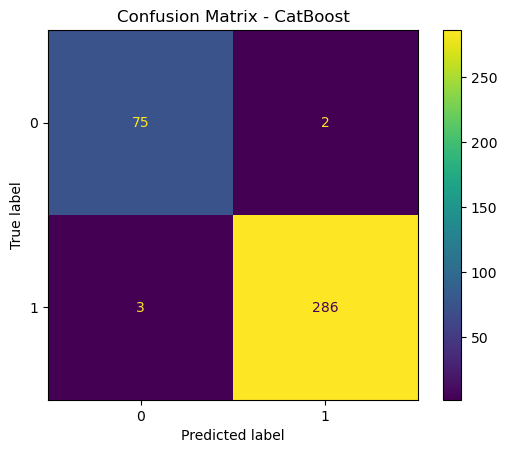

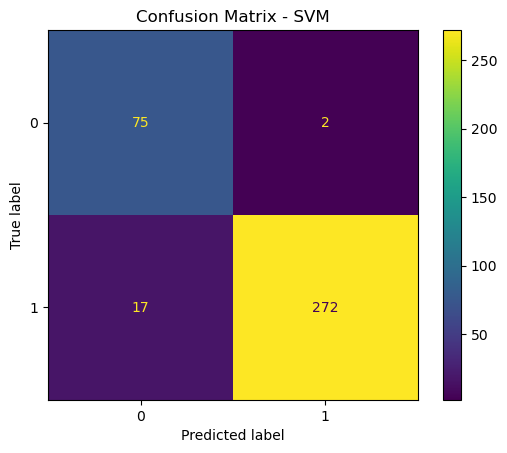

In [16]:
for model, name in [(catb, 'CatBoost'), (svm, 'SVM')]:
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

## 8. Kesimpulan dan Rekomendasi

### Perbandingan Kinerja Model:

# Perbandingan Hasil Modeling: CatBoost vs SVM (RBF)

## 1. Ringkasan Metrik

| Metrik / Model          | CatBoost         | SVM (RBF)        |
|-------------------------|------------------|------------------|
| **Accuracy**            | 0.99             | 0.95             |
| **Precision (kelas 0)** | 0.96             | 0.82             |
| **Recall (kelas 0)**    | 0.97             | 0.97             |
| **F1-score (kelas 0)**  | 0.97             | 0.89             |
| **Precision (kelas 1)** | 0.99             | 0.99             |
| **Recall (kelas 1)**    | 0.99             | 0.94             |
| **F1-score (kelas 1)**  | 0.99             | 0.97             |
| **False Positives (FP)**| 2                | 2                |
| **False Negatives (FN)**| 3                | 17               |

## 2. Interpretasi Hasil

- **Accuracy**  
  CatBoost mencapai 99 % akurasi, sedangkan SVM “hanya” 95 %. Artinya CatBoost berhasil mengklasifikasi hampir semua sampel dengan benar.

- **Precision & Recall Kelas 0**  
  - _CatBoost_—precision 0.96, recall 0.97: dari 77 sampel kelas 0, hanya 2 yang salah klasifikasi sebagai kelas 1 (FP), dan 3 sampel kelas 1 yang “tersangkut” sebagai kelas 0 (FN).  
  - _SVM_—precision 0.82, recall 0.97: meski recall-nya sama dengan CatBoost, precision jauh lebih rendah (hanya 82 %) karena banyak sampel kelas 1 (“Tidak Baik”) yang keliru diprediksi sebagai kelas 0 (17 FN).

- **Precision & Recall Kelas 1**  
  - _CatBoost_—precision & recall 0.99: sangat kuat dalam mendeteksi kategori “Tidak Baik” tanpa banyak salah prediksi.  
  - _SVM_—precision 0.99, recall 0.94: presisinya masih tinggi, namun recall sedikit menurun karena 17 sampel “Tidak Baik” tertinggal (FN).

- **Confusion Matrix**  
  - *CatBoost* menunjukkan matrix [[75, 2], [3, 286]]:
    - **True Negatives (TN)** = 75: sampel “Baik” terdeteksi benar.  
    - **False Positives (FP)** = 2: sampel “Baik” yang salah diprediksi “Tidak Baik”.  
    - **False Negatives (FN)** = 3: sampel “Tidak Baik” yang salah diprediksi “Baik”.  
    - **True Positives (TP)** = 286: sampel “Tidak Baik” terdeteksi benar.   

  - *SVM* menunjukkan matrix [[75, 2], [17, 272]]: 
    - **TN** = 75, **FP** = 2 sama seperti CatBoost untuk kelas “Baik”.  
    - **FN** = 17: jauh lebih banyak sampel “Tidak Baik” yang tertahan.  
    - **TP** = 272: sedikit menurun dibanding CatBoost.  

FN yang lebih sedikit di CatBoost menunjukkan kemampuannya yang lebih baik dalam menangkap kasus “Tidak Baik” (kelas minoritas), sehingga recall dan F1-score-nya lebih tinggi.

## 3. Kesimpulan

1. **CatBoost unggul** secara keseluruhan dengan akurasi, precision, recall, dan F1-score yang lebih tinggi di kedua kelas.  
2. **SVM (RBF)** masih cukup baik, tetapi cenderung “mengabaikan” lebih banyak sampel kelas 1, sehingga recall kelas 1 dan precision kelas 0 menurun.

## 4. Alasan Perbedaan Hasil

- **Algoritma & Tree-Based vs Kernel-Based**  
  CatBoost (tree-based gradient boosting) secara natural menangani fitur kategori dan outlier dengan lebih robust, sedangkan SVM (RBF) sangat sensitif ke pemilihan kernel, skala fitur, dan distribusi data.

- **Penanganan Imbalance & Regularisasi**  
  CatBoost memiliki mekanisme built-in untuk menangani kelas tidak seimbang dan overfitting (misalnya ordered boosting), sementara SVM perlu tuning parameter `C`, kernel dan scaling yang tepat agar tidak underfit/overfit.

- **Hyperparameter Default**  
  CatBoost seringkali memberikan performa kuat bahkan dengan hyperparameter default, sementara SVM membutuhkan pencarian grid (e.g. `C`, `gamma`) untuk mencapai hasil optimal.

---

> **Rekomendasi**: Jika goal-mu adalah memaksimalkan